In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download kaggle data in local machine and store in data folder
data = pd.read_csv("data/train.csv")  # https://www.kaggle.com/competitions/titanic/data?select=train.csv
test_data = pd.read_csv("data/test.csv")  # https://www.kaggle.com/competitions/titanic/data?select=test.csv

In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
from ydata_profiling import ProfileReport
# ProfileReport(data, title="Profiling Report")

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=22)

for train_indices, test_indices in split.split(data, data[["Survived", "Pclass", "Sex"]]):
    train_df = data.loc[train_indices]
    test_df = data.loc[test_indices]

In [7]:
test_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
501,502,0,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,NaN,S
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9000,NaN,S
460,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S
793,794,0,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C


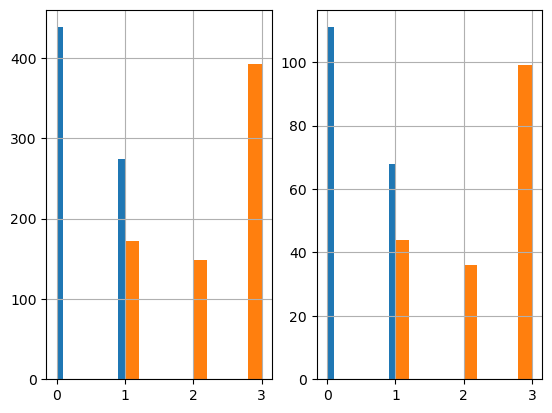

In [8]:
plt.subplot(1, 2, 1)
train_df["Survived"].hist()
train_df["Pclass"].hist()

plt.subplot(1, 2, 2)
test_df["Survived"].hist()
test_df["Pclass"].hist()

plt.show()

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, data):
        imputer = SimpleImputer(strategy="mean")
        data["Age"] = imputer.fit_transform(data[["Age"]])
        
        return data

In [10]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, data):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(data[["Embarked"]]).toarray()
        if len(matrix[0]) == 3:
            data.loc[:, ["C", "Q", "S"]] = matrix
        elif len(matrix[0]) == 4:
            data.loc[:, ["C", "Q", "S", "N"]] = matrix
        else:
            raise ValueError
        data.loc[:, ["Female", "Male"]] = encoder.fit_transform(data[["Sex"]]).toarray()
        
        return data

In [11]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, data):
        
        return data.drop(["Embarked", "Cabin", "Ticket", "Fare", "Name", "Sex", "N"], axis=1, errors="ignore")

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("encoder", FeatureEncoder()),
                     ("dropper", FeatureDropper())])

In [13]:
train_df = pipeline.fit_transform(train_df)

In [14]:
from sklearn.preprocessing import StandardScaler


X = train_df.drop(["Survived"], axis=1)
y = train_df["Survived"]
scalar = StandardScaler()

X_data = scalar.fit_transform(X)
y_data = y.to_numpy()

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [{"n_estimators": [10, 100, 200, 300, 500]},
              {"max_depth": [3, 5, 7]},
              {"min_samples_split": [2, 3, 4]}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, n_jobs=-1)
grid_search.fit(X_data, y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 200, 300, 500]},
                         {'max_depth': [3, 5, 7]},
                         {'min_samples_split': [2, 3, 4]}],
             return_train_score=True, scoring='accuracy')

In [16]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5)

In [17]:
test_df = pipeline.fit_transform(test_df)

X_test = test_df.drop(["Survived"], axis=1)
y_test = test_df["Survived"]
scalar = StandardScaler()

x_data_test = scalar.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [18]:
final_clf.score(x_data_test, y_data_test)

0.8100558659217877

In [19]:
final_data = pipeline.fit_transform(data)

X_final = final_data.drop(["Survived"], axis=1)
y_final = final_data["Survived"]
scalar = StandardScaler()

x_data_final = scalar.fit_transform(X_final)
y_data_final = y_final.to_numpy()

param_grid = [{"n_estimators": [10, 100, 200, 300, 500]},
              {"max_depth": [3, 5, 7]},
              {"min_samples_split": [2, 3, 4]}]

prod_grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, n_jobs=-1)
prod_grid_search.fit(x_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 200, 300, 500]},
                         {'max_depth': [3, 5, 7]},
                         {'min_samples_split': [2, 3, 4]}],
             return_train_score=True, scoring='accuracy')

In [20]:
prod_final_clf = prod_grid_search.best_estimator_

In [21]:
final_test_data = pipeline.fit_transform(test_data)

In [22]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   C            418 non-null    float64
 6   Q            418 non-null    float64
 7   S            418 non-null    float64
 8   Female       418 non-null    float64
 9   Male         418 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 32.8 KB


In [23]:
x_data_final_test = scalar.fit_transform(final_test_data)

predictions = prod_final_clf.predict(x_data_final_test)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [24]:
submission_df = pd.DataFrame(test_data["PassengerId"])
submission_df["Survived"] = predictions
submission_df.to_csv("data/titanic_submission.csv", index=False)